In [1]:
from google.colab import drive
# Mount Google Drive to access dataset and save models
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.models.segmentation as models
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Configuration class for paths, hyperparameters, and device settings
class Config:
    ROOT = "/content/drive/MyDrive/AI Based Oil Spill Detection"
    DATASET_PATH = f"{ROOT}/dataset"
    SAVE_MODEL_PATH = f"{ROOT}/best_deeplabv3_oilspill.pth"
    PRED_SAVE_DIR = f"{ROOT}/predictions"
    IMAGE_SIZE = (512, 512)
    BATCH_SIZE = 4
    LEARNING_RATE = 1e-4
    EPOCHS = 50
    NUM_CLASSES = 2
    NUM_WORKERS = 2
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    THRESHOLD = 0.5
    SPILL_COLOR = np.array([255, 0, 124], dtype=np.uint8)


cfg = Config()
os.makedirs(cfg.PRED_SAVE_DIR, exist_ok=True)

In [4]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

In [5]:
# Load class color info (from label_colors.txt)
colors_path = os.path.join(cfg.DATASET_PATH, "label_colors.txt")
if os.path.exists(colors_path):
    try:
        with open(colors_path, "r") as f:
            lines = [line.strip() for line in f if line.strip()]
        if len(lines) >= 2:
            parts = lines[1].replace(",", " ").split()
            rgb = [int(p) for p in parts if p.isdigit()]
            if len(rgb) >= 3:
                cfg.SPILL_COLOR = np.array(rgb[:3], dtype=np.uint8)
                print("Spill color:", cfg.SPILL_COLOR.tolist())
    except Exception as e:
        print("Error reading label_colors.txt:", e)

Spill color: [255, 0, 124]


In [6]:
# Helper to find matching mask for an image
def find_matching_mask(image_path, masks_dir):
    stem = os.path.splitext(os.path.basename(image_path))[0]
    for ext in (".png", ".jpg", ".jpeg"):
        candidate = os.path.join(masks_dir, stem + ext)
        if os.path.isfile(candidate):
            return candidate
    if os.path.isdir(masks_dir):
        for filename in os.listdir(masks_dir):
            if stem in os.path.splitext(filename)[0]:
                return os.path.join(masks_dir, filename)
    return None

In [7]:
# Dataset
class OilSpillDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None, spill_color_rgb=np.array([255, 0, 124], dtype=np.uint8)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms
        self.spill_color_rgb = spill_color_rgb
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if os.path.isfile(os.path.join(images_dir, f)) and f.lower().endswith((".png", ".jpg", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_files)

    def _mask_to_class(self, mask):
        return np.all(mask == self.spill_color_rgb, axis=-1).astype(np.uint8)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = find_matching_mask(img_path, self.masks_dir)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = self._mask_to_class(mask)
        else:
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        return img, mask, self.image_files[idx]

In [8]:
# Data augmentations (train vs validation)
def get_transforms(phase="train"):
    if phase == "train":
        return A.Compose([
            A.Resize(cfg.IMAGE_SIZE[0], cfg.IMAGE_SIZE[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(cfg.IMAGE_SIZE[0], cfg.IMAGE_SIZE[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [9]:
# ---------------- MODEL ----------------
def create_deeplabv3(num_classes):
    model = models.deeplabv3_resnet50(pretrained=True, progress=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model


In [10]:
# ---------------- LOSS ----------------
class DiceLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)[:, 1]
        targets_f = (targets == 1).float()
        inter = (probs * targets_f).sum()
        return 1 - (2. * inter + 1e-6) / (probs.sum() + targets_f.sum() + 1e-6)


class TverskyLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)[:, 1]
        targets_f = (targets == 1).float()
        TP = (probs * targets_f).sum()
        FP = (probs * (1 - targets_f)).sum()
        FN = ((1 - probs) * targets_f).sum()
        return 1 - (TP + 1e-6) / (TP + 0.7 * FP + 0.3 * FN + 1e-6)


class CombinedLoss(nn.Module):
    def forward(self, logits, targets):
        return 0.4 * nn.CrossEntropyLoss()(logits, targets) + \
               0.3 * TverskyLoss()(logits, targets) + \
               0.3 * DiceLoss()(logits, targets)


In [11]:
# ---------------- METRICS ----------------
@torch.no_grad()
def calc_metrics(preds, targets, num_classes=2):
    if preds.ndim == 2:
        preds = preds.unsqueeze(0)
        targets = targets.unsqueeze(0)

    preds_np = preds.cpu().numpy().astype(np.int32)
    targets_np = targets.cpu().numpy().astype(np.int32)

    acc = (preds_np == targets_np).mean()

    tp = np.logical_and(preds_np == 1, targets_np == 1).sum()
    fp = np.logical_and(preds_np == 1, targets_np == 0).sum()
    fn = np.logical_and(preds_np == 0, targets_np == 1).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    ious, dices = [], []
    for c in range(num_classes):
        pc = (preds_np == c)
        tc = (targets_np == c)
        inter = np.logical_and(pc, tc).sum()
        union = np.logical_or(pc, tc).sum()
        iou = inter / (union + 1e-6) if union > 0 else 1.0
        dice = (2 * inter) / (pc.sum() + tc.sum() + 1e-6) if (pc.sum() + tc.sum()) > 0 else 1.0
        ious.append(iou)
        dices.append(dice)

    miou = float(np.mean(ious))
    mdice = float(np.mean(dices))
    return acc, miou, mdice, precision, recall, f1

In [12]:
# DataLoaders for train/val/test
def make_loaders(cfg):
    use_cuda = torch.cuda.is_available()
    num_workers = 4 if use_cuda else 0
    pin_memory = True if use_cuda else False

    train_ds = OilSpillDataset(
        os.path.join(cfg.DATASET_PATH, "train", "images"),
        os.path.join(cfg.DATASET_PATH, "train", "masks"),
        transforms=get_transforms("train"),
        spill_color_rgb=cfg.SPILL_COLOR
    )

    val_ds = OilSpillDataset(
        os.path.join(cfg.DATASET_PATH, "val", "images"),
        os.path.join(cfg.DATASET_PATH, "val", "masks"),
        transforms=get_transforms("val"),
        spill_color_rgb=cfg.SPILL_COLOR
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, val_loader

In [13]:
# Early Stopping
class EarlyStopper:
    def __init__(self, patience=6, mode="max", min_delta=1e-4):
        """
        :param patience: How many bad epochs to wait before stopping.
        :param mode: "max" for metrics to be maximized (e.g., accuracy), "min" for metrics to be minimized (e.g., loss).
        :param min_delta: Minimum change to qualify as improvement.
        """
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = -np.inf if mode == "max" else np.inf
        self.num_bad = 0

    def step(self, value):
        if self.mode == "max":
            improved = value > self.best + self.min_delta
        else:
            improved = value < self.best - self.min_delta

        if improved:
            self.best = value
            self.num_bad = 0
            return True
        else:
            self.num_bad += 1
            return False

    def should_stop(self):
        return self.num_bad >= self.patience

In [14]:
# Training for one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    logs = {"loss": 0, "acc": 0, "miou": 0, "mdice": 0, "precision": 0, "recall": 0, "f1": 0}

    for imgs, masks, _ in tqdm(loader, desc="Train"):
        imgs, masks = imgs.to(device), masks.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            outs = model(imgs)["out"]
            loss = criterion(outs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc, miou, mdice, precision, recall, f1 = calc_metrics(torch.argmax(outs, dim=1), masks, cfg.NUM_CLASSES)

        logs["loss"] += loss.item()
        logs["acc"] += acc
        logs["miou"] += miou
        logs["mdice"] += mdice
        logs["precision"] += precision
        logs["recall"] += recall
        logs["f1"] += f1

    n = len(loader)
    return {k: v / n for k, v in logs.items()}


# Validation for one epoch
@torch.no_grad()
def val_one_epoch(model, loader, criterion, device):
    model.eval()
    logs = {"loss": 0, "acc": 0, "miou": 0, "mdice": 0, "precision": 0, "recall": 0, "f1": 0}

    for imgs, masks, _ in tqdm(loader, desc="Val"):
        imgs, masks = imgs.to(device), masks.to(device).long()

        outs = model(imgs)["out"]
        loss = criterion(outs, masks)

        acc, miou, mdice, precision, recall, f1 = calc_metrics(torch.argmax(outs, dim=1), masks, cfg.NUM_CLASSES)

        logs["loss"] += loss.item()
        logs["acc"] += acc
        logs["miou"] += miou
        logs["mdice"] += mdice
        logs["precision"] += precision
        logs["recall"] += recall
        logs["f1"] += f1

    n = len(loader)
    return {k: v / n for k, v in logs.items()}


# Main training loop
def main_train():
    train_loader, val_loader = make_loaders(cfg)

    # DeepLabV3 model with ResNet-50 backbone
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=cfg.NUM_CLASSES).to(cfg.DEVICE)

    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=5, factor=0.8)
    scaler = torch.amp.GradScaler(enabled=(cfg.DEVICE.type == "cuda"))
    early_stopper = EarlyStopper(patience=10, mode="max", min_delta=1e-5)

    best_iou = 0.0

    for epoch in range(cfg.EPOCHS):
        print(f"\nEpoch {epoch + 1}/{cfg.EPOCHS}")
        train_logs = train_one_epoch(model, train_loader, criterion, optimizer, scaler, cfg.DEVICE)
        val_logs = val_one_epoch(model, val_loader, criterion, cfg.DEVICE)

        print(f"Train: Loss={train_logs['loss']:.4f} | Acc={train_logs['acc']:.4f} | mIoU={train_logs['miou']:.4f} | mDice={train_logs['mdice']:.4f} | Precision={train_logs['precision']:.4f} | Recall={train_logs['recall']:.4f} | F1={train_logs['f1']:.4f}")
        print(f"Val  : Loss={val_logs['loss']:.4f} | Acc={val_logs['acc']:.4f} | mIoU={val_logs['miou']:.4f} | mDice={val_logs['mdice']:.4f} | Precision={val_logs['precision']:.4f} | Recall={val_logs['recall']:.4f} | F1={val_logs['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

        scheduler.step(val_logs["miou"])

        if val_logs["miou"] > best_iou:
            best_iou = val_logs["miou"]
            torch.save(model.state_dict(), cfg.SAVE_MODEL_PATH)
            print(f"✅ Saved best model (mIoU={best_iou:.4f})")

        # Early stopping check
        if not early_stopper.step(val_logs["miou"]) and early_stopper.should_stop():
            print("⏹️ Early stopping triggered.")
            break

    return model

In [15]:
# Post-processing: Remove small connected components
def clean_prediction(mask, min_size=100):
    mask_np = mask.cpu().numpy().astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)
    new_mask = np.zeros_like(mask_np)

    for i in range(1, num_labels):  # skip background label 0
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            new_mask[labels == i] = 1

    return torch.from_numpy(new_mask).to(mask.device)


# Evaluate model performance on a given loader
@torch.no_grad()
def evaluate_on_loader(model, loader, device, save_preds=False, save_dir=None, tta=False, threshold=0.65, clean=True, min_size=100):
    model.eval()
    tot_acc = tot_miou = tot_mdice = tot_precision = tot_recall = tot_f1 = 0.0
    n_batches = 0

    for imgs, masks, names in tqdm(loader, desc="Test"):
        imgs, masks = imgs.to(device), masks.to(device).long()

        if not tta:
            outs = model(imgs)["out"]  # DeepLabV3 output change
        else:
            outs = model(imgs)["out"]
            outs_flip = model(torch.flip(imgs, dims=[3]))["out"]  # DeepLabV3 output change
            outs_flip = torch.flip(outs_flip, dims=[3])
            outs = (outs + outs_flip) / 2.0

        acc, miou, mdice, precision, recall, f1 = calc_metrics(outs, masks, cfg.NUM_CLASSES)

        tot_acc += acc
        tot_miou += miou
        tot_mdice += mdice
        tot_precision += precision
        tot_recall += recall
        tot_f1 += f1
        n_batches += 1

        if save_preds and save_dir:
            os.makedirs(save_dir, exist_ok=True)
            probs = torch.softmax(outs, dim=1)[:, 1, :, :]
            preds = (probs > threshold).long()
            if clean:
                preds = torch.stack([clean_prediction(p, min_size=min_size) for p in preds])

            for i in range(preds.size(0)):
                pred = preds[i].cpu().numpy().astype(np.uint8) * 255
                cv2.imwrite(os.path.join(save_dir, f"pred_{names[i]}"), pred)

    return {
        "acc": tot_acc / n_batches,
        "miou": tot_miou / n_batches,
        "mdice": tot_mdice / n_batches,
        "precision": tot_precision / n_batches,
        "recall": tot_recall / n_batches,
        "f1": tot_f1 / n_batches
    }

In [ ]:
# Run Training & Eval
model = main_train()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments o

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]



Epoch 1/50


Val: 100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


Train: Loss=0.3886 | Acc=0.8238 | mIoU=0.6697 | mDice=0.7845 | Precision=0.6829 | Recall=0.7895 | F1=0.7009
Val  : Loss=0.3782 | Acc=0.8766 | mIoU=0.7072 | mDice=0.7953 | Precision=0.6648 | Recall=0.8512 | F1=0.7320
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.7072)

Epoch 2/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.71it/s]


Train: Loss=0.3028 | Acc=0.8685 | mIoU=0.7372 | mDice=0.8365 | Precision=0.7612 | Recall=0.8350 | F1=0.7707
Val  : Loss=0.2459 | Acc=0.9312 | mIoU=0.8193 | mDice=0.8764 | Precision=0.7805 | Recall=0.8073 | F1=0.7831
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8193)

Epoch 3/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.2899 | Acc=0.8715 | mIoU=0.7437 | mDice=0.8400 | Precision=0.7631 | Recall=0.8442 | F1=0.7767
Val  : Loss=0.2777 | Acc=0.9176 | mIoU=0.7947 | mDice=0.8608 | Precision=0.7510 | Recall=0.8494 | F1=0.7792
Learning Rate: 0.0001

Epoch 4/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.2696 | Acc=0.8810 | mIoU=0.7602 | mDice=0.8512 | Precision=0.7866 | Recall=0.8516 | F1=0.7931
Val  : Loss=0.2082 | Acc=0.9342 | mIoU=0.8324 | mDice=0.8853 | Precision=0.7877 | Recall=0.8232 | F1=0.7962
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8324)

Epoch 5/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.2370 | Acc=0.9007 | mIoU=0.7938 | mDice=0.8753 | Precision=0.8030 | Recall=0.8892 | F1=0.8264
Val  : Loss=0.2068 | Acc=0.9352 | mIoU=0.8224 | mDice=0.8759 | Precision=0.8177 | Recall=0.8160 | F1=0.8066
Learning Rate: 0.0001

Epoch 6/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.2171 | Acc=0.9114 | mIoU=0.8123 | mDice=0.8861 | Precision=0.8295 | Recall=0.8932 | F1=0.8396
Val  : Loss=0.1870 | Acc=0.9471 | mIoU=0.8565 | mDice=0.9026 | Precision=0.8070 | Recall=0.8404 | F1=0.8120
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8565)

Epoch 7/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.73it/s]


Train: Loss=0.2165 | Acc=0.9101 | mIoU=0.8098 | mDice=0.8842 | Precision=0.8237 | Recall=0.8825 | F1=0.8372
Val  : Loss=0.1854 | Acc=0.9496 | mIoU=0.8623 | mDice=0.9065 | Precision=0.8400 | Recall=0.8141 | F1=0.8170
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8623)

Epoch 8/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.2050 | Acc=0.9144 | mIoU=0.8179 | mDice=0.8912 | Precision=0.8430 | Recall=0.8832 | F1=0.8485
Val  : Loss=0.1862 | Acc=0.9449 | mIoU=0.8559 | mDice=0.9045 | Precision=0.8197 | Recall=0.8350 | F1=0.8200
Learning Rate: 0.0001

Epoch 9/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Train: Loss=0.2050 | Acc=0.9137 | mIoU=0.8163 | mDice=0.8890 | Precision=0.8339 | Recall=0.8867 | F1=0.8442
Val  : Loss=0.1768 | Acc=0.9478 | mIoU=0.8624 | mDice=0.9101 | Precision=0.8224 | Recall=0.8428 | F1=0.8283
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8624)

Epoch 10/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Train: Loss=0.2005 | Acc=0.9158 | mIoU=0.8194 | mDice=0.8913 | Precision=0.8435 | Recall=0.8803 | F1=0.8466
Val  : Loss=0.2065 | Acc=0.9259 | mIoU=0.8290 | mDice=0.8799 | Precision=0.8344 | Recall=0.7765 | F1=0.7827
Learning Rate: 0.0001

Epoch 11/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


Train: Loss=0.2017 | Acc=0.9155 | mIoU=0.8192 | mDice=0.8917 | Precision=0.8415 | Recall=0.8818 | F1=0.8480
Val  : Loss=0.1851 | Acc=0.9455 | mIoU=0.8306 | mDice=0.8790 | Precision=0.8287 | Recall=0.8374 | F1=0.8269
Learning Rate: 0.0001

Epoch 12/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1894 | Acc=0.9223 | mIoU=0.8331 | mDice=0.9005 | Precision=0.8501 | Recall=0.9009 | F1=0.8600
Val  : Loss=0.1881 | Acc=0.9429 | mIoU=0.8369 | mDice=0.8850 | Precision=0.8136 | Recall=0.8451 | F1=0.8204
Learning Rate: 0.0001

Epoch 13/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.1689 | Acc=0.9287 | mIoU=0.8468 | mDice=0.9096 | Precision=0.8613 | Recall=0.9156 | F1=0.8740
Val  : Loss=0.1629 | Acc=0.9526 | mIoU=0.8597 | mDice=0.9030 | Precision=0.8473 | Recall=0.8302 | F1=0.8330
Learning Rate: 0.0001

Epoch 14/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Train: Loss=0.1780 | Acc=0.9275 | mIoU=0.8409 | mDice=0.9055 | Precision=0.8685 | Recall=0.8934 | F1=0.8676
Val  : Loss=0.2366 | Acc=0.9172 | mIoU=0.8037 | mDice=0.8624 | Precision=0.7749 | Recall=0.8675 | F1=0.8013
Learning Rate: 0.0001

Epoch 15/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.76it/s]


Train: Loss=0.1664 | Acc=0.9309 | mIoU=0.8475 | mDice=0.9102 | Precision=0.8662 | Recall=0.9049 | F1=0.8725
Val  : Loss=0.1635 | Acc=0.9513 | mIoU=0.8687 | mDice=0.9134 | Precision=0.8600 | Recall=0.8098 | F1=0.8239
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8687)

Epoch 16/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.1736 | Acc=0.9307 | mIoU=0.8500 | mDice=0.9097 | Precision=0.8632 | Recall=0.9036 | F1=0.8718
Val  : Loss=0.1544 | Acc=0.9556 | mIoU=0.8645 | mDice=0.9085 | Precision=0.8578 | Recall=0.8190 | F1=0.8339
Learning Rate: 0.0001

Epoch 17/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


Train: Loss=0.1616 | Acc=0.9350 | mIoU=0.8569 | mDice=0.9156 | Precision=0.8714 | Recall=0.9131 | F1=0.8812
Val  : Loss=0.1428 | Acc=0.9605 | mIoU=0.8787 | mDice=0.9192 | Precision=0.8508 | Recall=0.8734 | F1=0.8552
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8787)

Epoch 18/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.1496 | Acc=0.9389 | mIoU=0.8637 | mDice=0.9213 | Precision=0.8851 | Recall=0.9145 | F1=0.8892
Val  : Loss=0.1645 | Acc=0.9487 | mIoU=0.8661 | mDice=0.9089 | Precision=0.8514 | Recall=0.8163 | F1=0.8209
Learning Rate: 0.0001

Epoch 19/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Train: Loss=0.1666 | Acc=0.9321 | mIoU=0.8484 | mDice=0.9108 | Precision=0.8666 | Recall=0.9112 | F1=0.8737
Val  : Loss=0.1491 | Acc=0.9583 | mIoU=0.8814 | mDice=0.9230 | Precision=0.8620 | Recall=0.8234 | F1=0.8373
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8814)

Epoch 20/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.1664 | Acc=0.9302 | mIoU=0.8488 | mDice=0.9101 | Precision=0.8652 | Recall=0.9103 | F1=0.8737
Val  : Loss=0.1652 | Acc=0.9554 | mIoU=0.8747 | mDice=0.9183 | Precision=0.8305 | Recall=0.8747 | F1=0.8411
Learning Rate: 0.0001

Epoch 21/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.1548 | Acc=0.9386 | mIoU=0.8612 | mDice=0.9185 | Precision=0.8845 | Recall=0.9043 | F1=0.8847
Val  : Loss=0.1452 | Acc=0.9632 | mIoU=0.8877 | mDice=0.9271 | Precision=0.8440 | Recall=0.8551 | F1=0.8450
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8877)

Epoch 22/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.1566 | Acc=0.9341 | mIoU=0.8558 | mDice=0.9147 | Precision=0.8720 | Recall=0.9096 | F1=0.8795
Val  : Loss=0.1317 | Acc=0.9679 | mIoU=0.8889 | mDice=0.9234 | Precision=0.8490 | Recall=0.8603 | F1=0.8536
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.8889)

Epoch 23/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.1493 | Acc=0.9399 | mIoU=0.8647 | mDice=0.9202 | Precision=0.8856 | Recall=0.9137 | F1=0.8854
Val  : Loss=0.1298 | Acc=0.9695 | mIoU=0.9017 | mDice=0.9351 | Precision=0.8501 | Recall=0.8668 | F1=0.8574
Learning Rate: 0.0001
✅ Saved best model (mIoU=0.9017)

Epoch 24/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Train: Loss=0.1499 | Acc=0.9412 | mIoU=0.8667 | mDice=0.9204 | Precision=0.8787 | Recall=0.9145 | F1=0.8850
Val  : Loss=0.1531 | Acc=0.9592 | mIoU=0.8784 | mDice=0.9192 | Precision=0.8408 | Recall=0.8476 | F1=0.8366
Learning Rate: 0.0001

Epoch 25/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.1451 | Acc=0.9396 | mIoU=0.8675 | mDice=0.9231 | Precision=0.8875 | Recall=0.9198 | F1=0.8922
Val  : Loss=0.1377 | Acc=0.9669 | mIoU=0.8948 | mDice=0.9311 | Precision=0.8494 | Recall=0.8546 | F1=0.8485
Learning Rate: 0.0001

Epoch 26/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Train: Loss=0.1442 | Acc=0.9406 | mIoU=0.8705 | mDice=0.9238 | Precision=0.8889 | Recall=0.9194 | F1=0.8927
Val  : Loss=0.1333 | Acc=0.9677 | mIoU=0.8988 | mDice=0.9332 | Precision=0.8540 | Recall=0.8605 | F1=0.8549
Learning Rate: 0.0001

Epoch 27/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.73it/s]


Train: Loss=0.1381 | Acc=0.9441 | mIoU=0.8758 | mDice=0.9264 | Precision=0.8889 | Recall=0.9217 | F1=0.8958
Val  : Loss=0.1327 | Acc=0.9656 | mIoU=0.8953 | mDice=0.9297 | Precision=0.8507 | Recall=0.8570 | F1=0.8504
Learning Rate: 0.0001

Epoch 28/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1214 | Acc=0.9512 | mIoU=0.8887 | mDice=0.9366 | Precision=0.9022 | Recall=0.9336 | F1=0.9104
Val  : Loss=0.1315 | Acc=0.9672 | mIoU=0.8961 | mDice=0.9311 | Precision=0.8550 | Recall=0.8534 | F1=0.8516
Learning Rate: 0.0001

Epoch 29/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Train: Loss=0.1412 | Acc=0.9439 | mIoU=0.8718 | mDice=0.9251 | Precision=0.8916 | Recall=0.9134 | F1=0.8928
Val  : Loss=0.1957 | Acc=0.9399 | mIoU=0.8258 | mDice=0.8761 | Precision=0.7985 | Recall=0.8540 | F1=0.8158
Learning Rate: 0.0001

Epoch 30/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.1310 | Acc=0.9469 | mIoU=0.8794 | mDice=0.9298 | Precision=0.8915 | Recall=0.9262 | F1=0.8999
Val  : Loss=0.1284 | Acc=0.9676 | mIoU=0.8886 | mDice=0.9255 | Precision=0.8745 | Recall=0.8565 | F1=0.8569
Learning Rate: 8e-05

Epoch 31/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1358 | Acc=0.9460 | mIoU=0.8768 | mDice=0.9277 | Precision=0.8895 | Recall=0.9251 | F1=0.8963
Val  : Loss=0.1437 | Acc=0.9642 | mIoU=0.8925 | mDice=0.9283 | Precision=0.8436 | Recall=0.8551 | F1=0.8455
Learning Rate: 8e-05

Epoch 32/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.79it/s]


Train: Loss=0.1392 | Acc=0.9466 | mIoU=0.8757 | mDice=0.9252 | Precision=0.8933 | Recall=0.9112 | F1=0.8906
Val  : Loss=0.1296 | Acc=0.9702 | mIoU=0.8963 | mDice=0.9295 | Precision=0.8549 | Recall=0.8672 | F1=0.8596
Learning Rate: 8e-05

Epoch 33/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.1165 | Acc=0.9561 | mIoU=0.8914 | mDice=0.9370 | Precision=0.9056 | Recall=0.9259 | F1=0.9078
Val  : Loss=0.1279 | Acc=0.9685 | mIoU=0.9043 | mDice=0.9378 | Precision=0.8530 | Recall=0.8643 | F1=0.8564
Learning Rate: 8e-05
✅ Saved best model (mIoU=0.9043)

Epoch 34/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1333 | Acc=0.9484 | mIoU=0.8766 | mDice=0.9258 | Precision=0.8908 | Recall=0.9185 | F1=0.8914
Val  : Loss=0.1464 | Acc=0.9555 | mIoU=0.8816 | mDice=0.9209 | Precision=0.8531 | Recall=0.8432 | F1=0.8434
Learning Rate: 8e-05

Epoch 35/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.1174 | Acc=0.9518 | mIoU=0.8899 | mDice=0.9364 | Precision=0.9135 | Recall=0.9233 | F1=0.9115
Val  : Loss=0.1537 | Acc=0.9528 | mIoU=0.8662 | mDice=0.9073 | Precision=0.8442 | Recall=0.8464 | F1=0.8374
Learning Rate: 8e-05

Epoch 36/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Train: Loss=0.1177 | Acc=0.9564 | mIoU=0.8929 | mDice=0.9377 | Precision=0.9126 | Recall=0.9260 | F1=0.9087
Val  : Loss=0.1286 | Acc=0.9712 | mIoU=0.8952 | mDice=0.9280 | Precision=0.8536 | Recall=0.8630 | F1=0.8546
Learning Rate: 8e-05

Epoch 37/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


Train: Loss=0.1145 | Acc=0.9545 | mIoU=0.8945 | mDice=0.9391 | Precision=0.9083 | Recall=0.9365 | F1=0.9129
Val  : Loss=0.1385 | Acc=0.9635 | mIoU=0.8956 | mDice=0.9316 | Precision=0.8392 | Recall=0.8740 | F1=0.8537
Learning Rate: 8e-05

Epoch 38/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.79it/s]


Train: Loss=0.1122 | Acc=0.9551 | mIoU=0.8968 | mDice=0.9403 | Precision=0.9148 | Recall=0.9361 | F1=0.9159
Val  : Loss=0.1269 | Acc=0.9725 | mIoU=0.9083 | mDice=0.9399 | Precision=0.8650 | Recall=0.8509 | F1=0.8546
Learning Rate: 8e-05
✅ Saved best model (mIoU=0.9083)

Epoch 39/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1118 | Acc=0.9560 | mIoU=0.8962 | mDice=0.9398 | Precision=0.9156 | Recall=0.9247 | F1=0.9132
Val  : Loss=0.1212 | Acc=0.9740 | mIoU=0.9091 | mDice=0.9401 | Precision=0.8597 | Recall=0.8638 | F1=0.8597
Learning Rate: 8e-05
✅ Saved best model (mIoU=0.9091)

Epoch 40/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.76it/s]


Train: Loss=0.1032 | Acc=0.9572 | mIoU=0.9008 | mDice=0.9439 | Precision=0.9203 | Recall=0.9354 | F1=0.9214
Val  : Loss=0.1272 | Acc=0.9706 | mIoU=0.9043 | mDice=0.9369 | Precision=0.8504 | Recall=0.8694 | F1=0.8581
Learning Rate: 8e-05

Epoch 41/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]


Train: Loss=0.1158 | Acc=0.9525 | mIoU=0.8932 | mDice=0.9381 | Precision=0.9088 | Recall=0.9296 | F1=0.9130
Val  : Loss=0.1244 | Acc=0.9718 | mIoU=0.8970 | mDice=0.9283 | Precision=0.8513 | Recall=0.8714 | F1=0.8596
Learning Rate: 8e-05

Epoch 42/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.79it/s]


Train: Loss=0.1039 | Acc=0.9577 | mIoU=0.9022 | mDice=0.9453 | Precision=0.9213 | Recall=0.9355 | F1=0.9231
Val  : Loss=0.1223 | Acc=0.9715 | mIoU=0.8990 | mDice=0.9313 | Precision=0.8600 | Recall=0.8638 | F1=0.8605
Learning Rate: 8e-05

Epoch 43/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.1035 | Acc=0.9583 | mIoU=0.9028 | mDice=0.9458 | Precision=0.9248 | Recall=0.9348 | F1=0.9249
Val  : Loss=0.1428 | Acc=0.9601 | mIoU=0.8881 | mDice=0.9255 | Precision=0.8626 | Recall=0.8326 | F1=0.8389
Learning Rate: 8e-05

Epoch 44/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1034 | Acc=0.9577 | mIoU=0.9006 | mDice=0.9446 | Precision=0.9257 | Recall=0.9273 | F1=0.9212
Val  : Loss=0.1403 | Acc=0.9671 | mIoU=0.8876 | mDice=0.9231 | Precision=0.8397 | Recall=0.8647 | F1=0.8507
Learning Rate: 8e-05

Epoch 45/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]


Train: Loss=0.1042 | Acc=0.9579 | mIoU=0.9018 | mDice=0.9454 | Precision=0.9241 | Recall=0.9331 | F1=0.9231
Val  : Loss=0.1286 | Acc=0.9716 | mIoU=0.9039 | mDice=0.9356 | Precision=0.8490 | Recall=0.8726 | F1=0.8567
Learning Rate: 8e-05

Epoch 46/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


Train: Loss=0.1067 | Acc=0.9571 | mIoU=0.8988 | mDice=0.9421 | Precision=0.9177 | Recall=0.9298 | F1=0.9174
Val  : Loss=0.1335 | Acc=0.9708 | mIoU=0.9066 | mDice=0.9392 | Precision=0.8570 | Recall=0.8671 | F1=0.8602
Learning Rate: 6.400000000000001e-05

Epoch 47/50


Val: 100%|██████████| 51/51 [00:27<00:00,  1.83it/s]


Train: Loss=0.0986 | Acc=0.9591 | mIoU=0.9068 | mDice=0.9478 | Precision=0.9281 | Recall=0.9363 | F1=0.9262
Val  : Loss=0.1202 | Acc=0.9727 | mIoU=0.9100 | mDice=0.9409 | Precision=0.8624 | Recall=0.8653 | F1=0.8618
Learning Rate: 6.400000000000001e-05
✅ Saved best model (mIoU=0.9100)

Epoch 48/50


Val: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Train: Loss=0.0918 | Acc=0.9637 | mIoU=0.9143 | mDice=0.9518 | Precision=0.9331 | Recall=0.9365 | F1=0.9314
Val  : Loss=0.1312 | Acc=0.9674 | mIoU=0.9022 | mDice=0.9348 | Precision=0.8507 | Recall=0.8774 | F1=0.8609
Learning Rate: 6.400000000000001e-05

Epoch 49/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


Train: Loss=0.0956 | Acc=0.9628 | mIoU=0.9099 | mDice=0.9491 | Precision=0.9239 | Recall=0.9431 | F1=0.9271
Val  : Loss=0.1271 | Acc=0.9683 | mIoU=0.8926 | mDice=0.9270 | Precision=0.8626 | Recall=0.8604 | F1=0.8582
Learning Rate: 6.400000000000001e-05

Epoch 50/50


Val: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]

Train: Loss=0.0961 | Acc=0.9641 | mIoU=0.9127 | mDice=0.9499 | Precision=0.9328 | Recall=0.9330 | F1=0.9266
Val  : Loss=0.1239 | Acc=0.9746 | mIoU=0.9067 | mDice=0.9357 | Precision=0.8601 | Recall=0.8730 | F1=0.8651
Learning Rate: 6.400000000000001e-05


In [16]:
# Visualization with boundary maps
@torch.no_grad()
def visualize_predictions_with_overlay(model, loader, device, num_samples=3, save_dir=None):
    model.eval()
    imgs, masks, names = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    # Forward pass (DeepLabV3 returns dict with 'out')
    outs = model(imgs)['out']
    preds = torch.argmax(outs, dim=1)

    for i in range(min(num_samples, imgs.size(0))):
        img = imgs[i].cpu().permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        mask = masks[i]   # tensor
        pred = preds[i]   # tensor

        mask_np = mask.cpu().numpy()
        pred_np = pred.cpu().numpy()

        # Overlays
        def make_overlay(img, binary, color):
            overlay = np.zeros_like(img)
            overlay[binary==1] = color
            return 0.7*img + 0.3*overlay

        gt_overlay   = make_overlay(img, mask_np, np.array([0,1,0]))   # green
        pr_overlay   = make_overlay(img, pred_np, np.array([1,0,0]))   # red
        both = np.zeros_like(img)
        both[mask_np==1] = [0,1,0]
        both[pred_np==1] = [1,0,0]
        both[(mask_np==1) & (pred_np==1)] = [1,1,0]  # yellow overlap
        combo_overlay = 0.7*img + 0.3*both

        # Plot overlays
        plt.figure(figsize=(16,5))
        plt.subplot(1,4,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(gt_overlay); plt.title("GT Overlay"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(pr_overlay); plt.title("Pred Overlay"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(combo_overlay); plt.title("GT vs Pred"); plt.axis("off")
        plt.tight_layout(); plt.show()

        # Save if needed
        if save_dir:
            out_path = os.path.join(save_dir, f"vis_{names[i]}")
            cv2.imwrite(out_path, cv2.cvtColor((combo_overlay*255).astype(np.uint8), cv2.COLOR_RGB2BGR))


# Load DeepLabV3 model
best_model = deeplabv3_resnet50(weights=None, num_classes=cfg.NUM_CLASSES).to(cfg.DEVICE)

# Load trained weights
best_model.load_state_dict(torch.load(cfg.SAVE_MODEL_PATH, map_location=cfg.DEVICE))
best_model.eval()

# Validation loader
val_loader = DataLoader(
    OilSpillDataset(os.path.join(cfg.DATASET_PATH,"val","images"),
                       os.path.join(cfg.DATASET_PATH,"val","masks"),
                       transforms=get_transforms("val"),
                       spill_color_rgb=cfg.SPILL_COLOR),
    batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True
)

# Run visualization
visualize_predictions_with_overlay(best_model, val_loader, cfg.DEVICE, num_samples=3)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
@torch.no_grad()
def evaluate_on_loader(model, loader, device, save_preds=False, save_dir=None, tta=False):
    model.eval()
    tot_acc = tot_miou = tot_mdice = tot_precision = tot_recall = tot_f1 = 0.0
    n_batches = 0

    # Define color map (extend if you have more than 2 classes)
    color_map = {
        0: (0, 0, 0),       # background = black
        1: (0, 0, 255),     # spill = red
        2: (0, 255, 0),     # extra class = green (if any)
        3: (255, 0, 0),     # extra class = blue (if any)
    }

    for imgs, masks, names in tqdm(loader, desc="Test"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        if not tta:
            outs = model(imgs)['out']
        else:
            # simple TTA: identity + horizontal flip
            outs = model(imgs)['out']
            outs_flip = model(torch.flip(imgs, dims=[3]))['out']
            outs_flip = torch.flip(outs_flip, dims=[3])
            outs = (outs + outs_flip) / 2.0

        preds = torch.argmax(outs, dim=1)

        # Unpack metrics
        acc, miou, mdice, precision, recall, f1 = calc_metrics(preds, masks, cfg.NUM_CLASSES)

        tot_acc += acc
        tot_miou += miou
        tot_mdice += mdice
        tot_precision += precision
        tot_recall += recall
        tot_f1 += f1
        n_batches += 1

        if save_preds and save_dir:
            for i in range(preds.size(0)):
                pred = preds[i].cpu().numpy().astype(np.uint8)

                # Convert prediction to color mask
                color_mask = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
                for cls_id, color in color_map.items():
                    color_mask[pred == cls_id] = color

                # Save colored prediction
                out_path = os.path.join(save_dir, f"pred_{names[i]}")
                cv2.imwrite(out_path, cv2.cvtColor(color_mask, cv2.COLOR_RGB2BGR))

    return (tot_acc / n_batches, tot_miou / n_batches, tot_mdice / n_batches,
            tot_precision / n_batches, tot_recall / n_batches, tot_f1 / n_batches)


# Setup test data loader
test_loader = DataLoader(
    OilSpillDataset(
        os.path.join(cfg.DATASET_PATH, "test", "images"),
        os.path.join(cfg.DATASET_PATH, "test", "masks"),
        transforms=get_transforms("val"),
        spill_color_rgb=cfg.SPILL_COLOR
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

# Run evaluation
acc, miou, mdice, precision, recall, f1 = evaluate_on_loader(
    best_model,
    test_loader,
    cfg.DEVICE,
    save_preds=True,
    save_dir=cfg.PRED_SAVE_DIR,
    tta=True
)

# Print results
print(f"\nTest set — Acc: {acc:.4f}  mIoU: {miou:.4f}  mDice: {mdice:.4f}")
print(f"Precision: {precision:.4f}  Recall: {recall:.4f}  F1 Score: {f1:.4f}")
print(f"Predictions saved to: {cfg.PRED_SAVE_DIR}")

Test: 100%|██████████| 64/64 [02:36<00:00,  2.44s/it]


Test set — Acc: 0.9698  mIoU: 0.9030  mDice: 0.9354
Precision: 0.8228  Recall: 0.8313  F1 Score: 0.8238
Predictions saved to: /content/drive/MyDrive/AI Based Oil Spill Detection/predictions


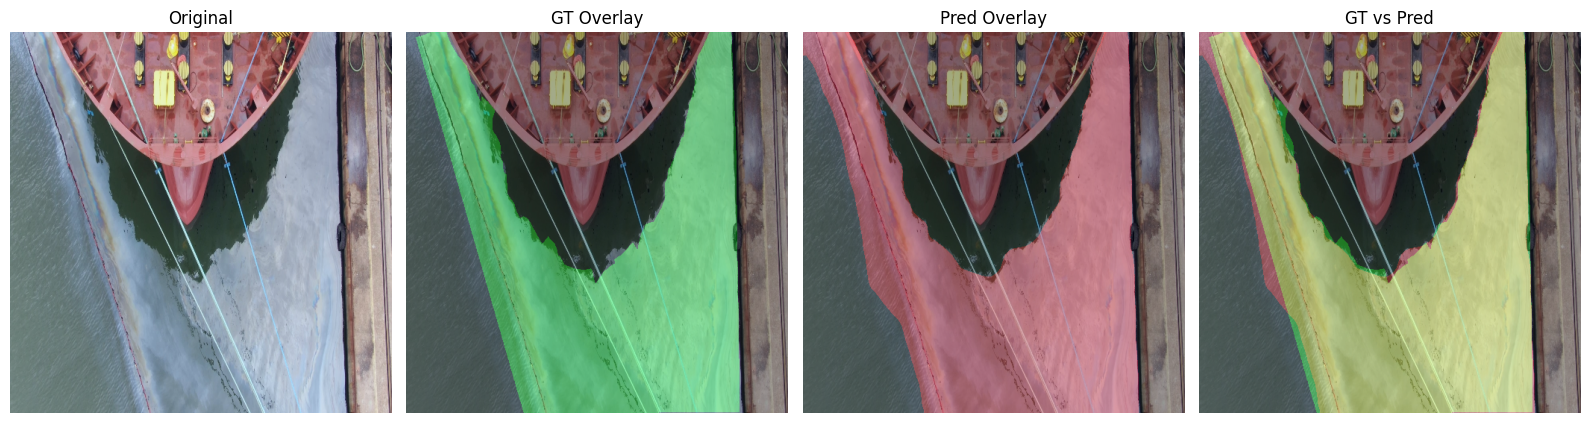

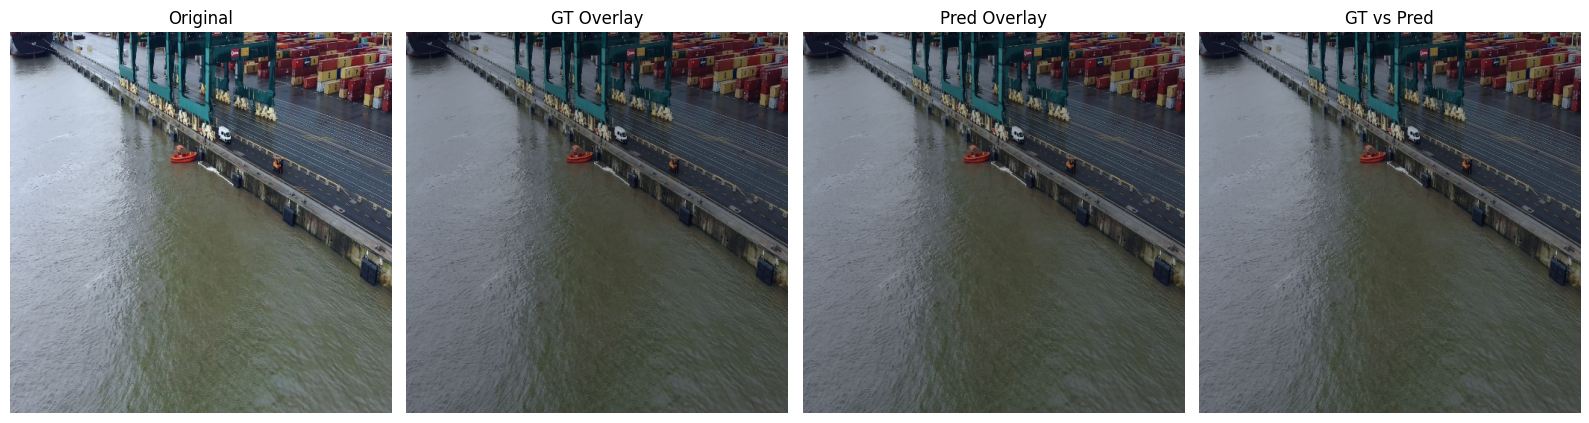

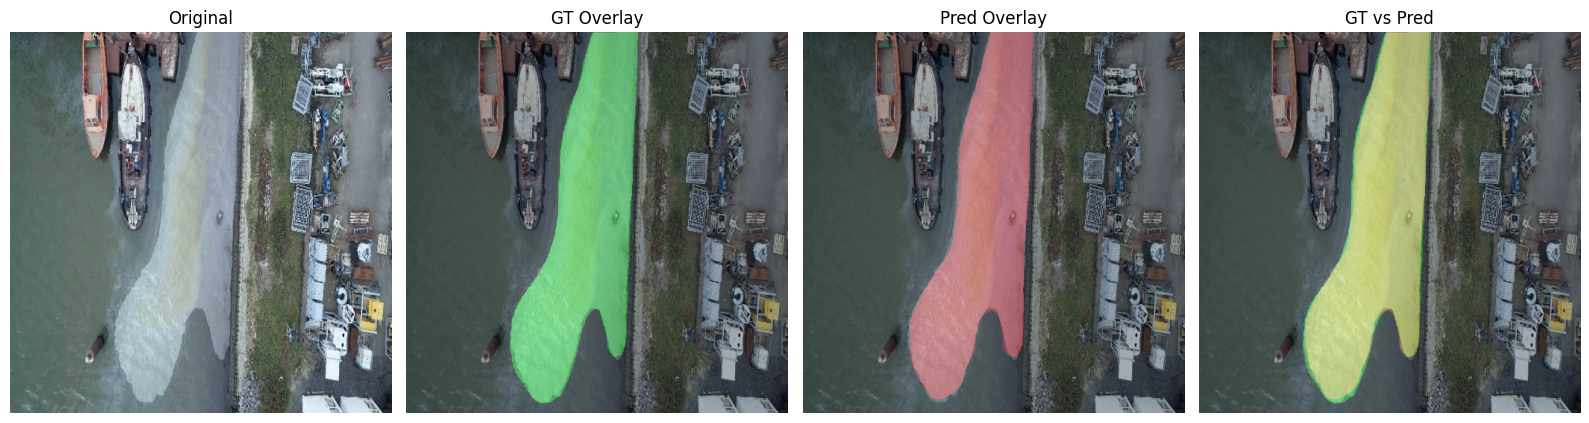

In [ ]:
# Run visualization
visualize_predictions_with_overlay(best_model, val_loader, cfg.DEVICE, num_samples=3)